# Phase One: Data Collection & Cleaning (Pure Polars)
## Portfolio Management PPI Modeling Project

**Objective**: Collect and clean data for forecasting month-on-month percentage changes in PPI for portfolio management services (PPIDF01 Index).

**Key Data Sources**:
- Primary Target: PPIDF01 Index (PPI Portfolio Management, NSA) from FRED
- Market Returns: S&P 500, NASDAQ, Russell 2000, VIX
- Bond Markets: Treasury yields, corporate spreads
- Macro Indicators: Dollar index, commodities, employment data

**Technical Stack**: Pure Polars for all data manipulation, FRED API, caching system

In [ ]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
load_dotenv()

# Import our data collection module
from data_collection import DataCollector

# Configure Polars
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(8)

print(f"Pure Polars setup complete - Version: {pl.__version__}")

In [ ]:
# Check API key
fred_key = os.getenv('FRED_API_KEY')
if fred_key:
    print(f"FRED API key configured: {fred_key[:8]}...")
else:
    print("WARNING: FRED API key not found! Set FRED_API_KEY in .env file")

# Initialize collector
collector = DataCollector(cache_dir="data_cache")
print(f"Data collector initialized with cache: {collector.cache_dir}")

In [ ]:
# Collect all data
print("Starting data collection...")
all_data = collector.collect_all_data()

# Quick summary
target = all_data['target']
if target is not None:
    print(f"\nTarget data: {target.shape} - {target['date'].min()} to {target['date'].max()}")
    
    # Show basic stats
    stats = target.select([
        pl.col('value').count().alias('count'),
        pl.col('value').mean().alias('mean'),
        pl.col('value').std().alias('std'),
        pl.col('value').min().alias('min'),
        pl.col('value').max().alias('max')
    ])
    print("Target statistics:")
    print(stats)

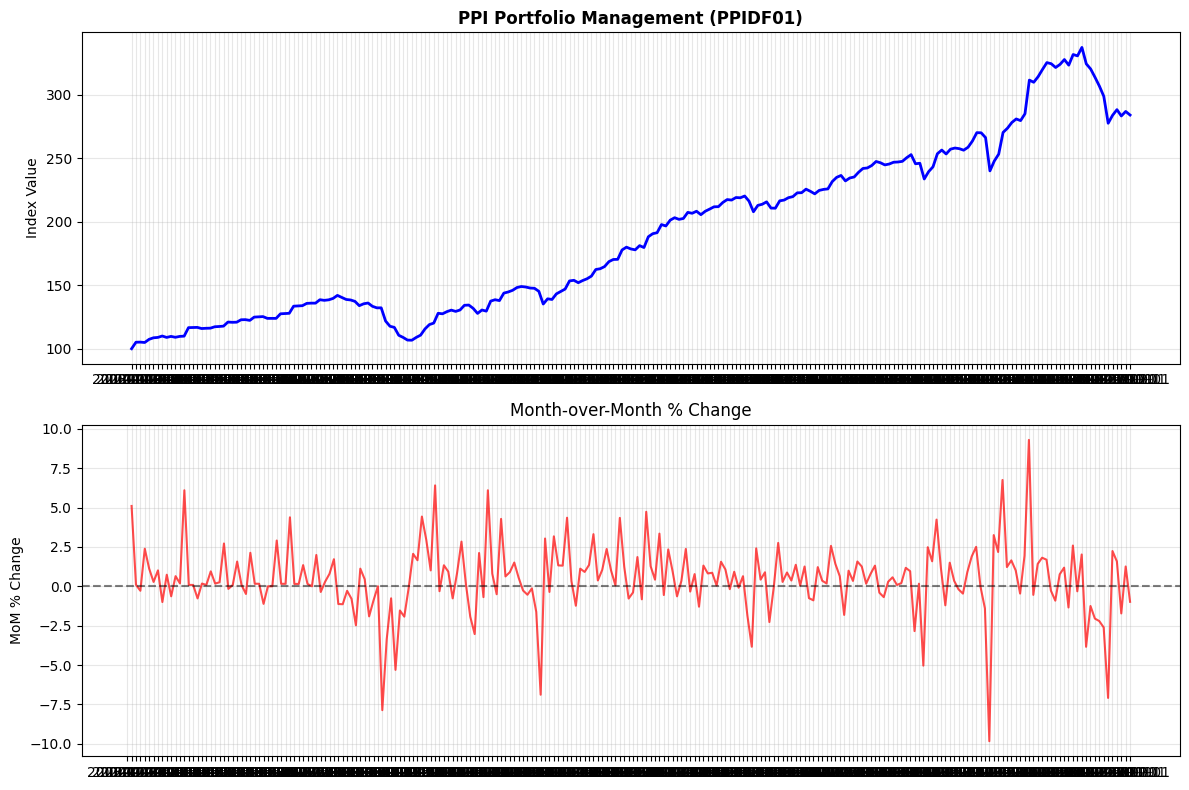


MoM % Change Statistics:
shape: (1, 4)
┌──────────┬─────────┬───────────┬──────────┐
│ mean_mom ┆ std_mom ┆ min_mom   ┆ max_mom  │
│ ---      ┆ ---     ┆ ---       ┆ ---      │
│ f64      ┆ f64     ┆ f64       ┆ f64      │
╞══════════╪═════════╪═══════════╪══════════╡
│ 0.482907 ┆ 2.18716 ┆ -9.838528 ┆ 9.294984 │
└──────────┴─────────┴───────────┴──────────┘


In [4]:
# Calculate MoM changes and visualize
if target is not None:
    target_enhanced = target.sort('date').with_columns([
        (pl.col('value').pct_change() * 100).alias('mom_pct')
    ])
    
    # Plot using matplotlib
    dates = target_enhanced['date'].to_numpy()
    values = target_enhanced['value'].to_numpy()
    mom_pct = target_enhanced['mom_pct'].to_numpy()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(dates, values, 'b-', linewidth=2)
    ax1.set_title('PPI Portfolio Management (PPIDF01)', fontweight='bold')
    ax1.set_ylabel('Index Value')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(dates, mom_pct, 'r-', linewidth=1.5, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Month-over-Month % Change')
    ax2.set_ylabel('MoM % Change')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # MoM statistics
    mom_stats = target_enhanced.select([
        pl.col('mom_pct').drop_nulls().mean().alias('mean_mom'),
        pl.col('mom_pct').drop_nulls().std().alias('std_mom'),
        pl.col('mom_pct').drop_nulls().min().alias('min_mom'),
        pl.col('mom_pct').drop_nulls().max().alias('max_mom')
    ])
    print("\nMoM % Change Statistics:")
    print(mom_stats)

In [ ]:
# Save data in Parquet format for optimal Polars performance
parquet_dir = Path("data_cache/parquet")
parquet_dir.mkdir(parents=True, exist_ok=True)

# Save target
if target is not None:
    target.write_parquet(parquet_dir / "target_ppidf01.parquet")
    print("Target data saved as Parquet")

# Save other data
for category, data_dict in all_data.items():
    if category != 'target' and isinstance(data_dict, dict):
        for name, df in data_dict.items():
            if isinstance(df, pl.DataFrame):
                filename = f"{category}_{name.lower()}.parquet"
                df.write_parquet(parquet_dir / filename)
                print(f"{category} {name} saved")

print(f"\nAll data saved to {parquet_dir}")
print("Phase One Complete - Pure Polars Implementation")